# MLP
Gudenas data.
Normalize by sum.
Change model.

In [1]:
from datetime import datetime
print(datetime.now())

2023-07-13 16:48:15.234217


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/'  # must end in "/"
except:
    IN_COLAB = False
    print('Running on Mac')
    DATA_DIR="/Users/jasonmiller/WVU/Localization/"

2023-07-13 16:48:15.291748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU device not found
Running on Mac


2023-07-13 16:48:26.332809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # time and sleep functions
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

DCELLS=16
EPOCHS=10 
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_100'

Python 3.10.0
sklearn 1.1.2


In [4]:
MAX_LINES_TO_LOAD =    10 # use this for debugging
MAX_LINES_TO_LOAD = None

DATA_FILE_0 = 'Gudenas/Gudenas.Supplement.Data1.csv'

print('Data directory: %s'%DATA_DIR)
print('Data file 0 %s'%DATA_FILE_0)

Data directory: /Users/jasonmiller/WVU/Localization/
Data file 0 Gudenas/Gudenas.Supplement.Data1.csv


## Data Load

In [5]:
class DataLoader():
    def __init__(self,filepath1,verbose=True):
        self.file = filepath1
        self.verbose = verbose
        self.max_lines = None

    def set_max_lines(self,lines):
        '''Limit the dataset size to fit in RAM.'''
        self.max_lines = lines
        if self.verbose:
            print('Maximum lines to load per file: %d'%lines)

    def load_full_train_set(self):
        minimum = 0
        max_lines = self.max_lines
        num_lines = 0
        header = None
        self.id = []
        self.fold_change = []
        self.label = []
        self.feature = []
        self.names = []
        try:
            with open(self.file,'r') as fin:
                for line in fin:
                    line=line.strip()
                    fields=line.split(',')
                    if header is None:
                        header = fields
                        self.names = fields
                        continue
                    if max_lines is not None and num_lines >= max_lines:
                        break
                    num_lines += 1
                    # Retain critical info about each sample
                    self.id.append(fields[0])
                    self.fold_change.append(fields[1])
                    if fields[-1] =='Cytosol':
                        self.label.append(0)
                    else:  # Nucleus
                        self.label.append(1)
                    # Zero out columns that give away the answer!
                    fields[0]=0. # ID
                    fields[1]=0. # fold change
                    fields[-1]=0. # cytosol/nucleus label
                    #for i in range(len(fields)):
                    #    #if header[i].startswith('chromosome'):
                    #    if header[i].isdigit():
                    #        fields[i] = int(0.5+np.log(int(fields[i])))
                    # Change GC content from fraction to percent
                    ##fields[3]=100.0*float(fields[3])+0.5  
                    # Change all columns to integers
                    floats = list(map(float,fields))
                    self.feature.append(floats)
        except Exception as e:
            print(e)
            raise Exception('CANNOT LOAD DATA FROM FILE!')
            
    def get_names(self):
        return self.names

    def show_examples(self,how_many=3):
        for i in range(how_many):
            print(self.id[i], self.fold_change[i],self.label[i])
            print(self.feature[i])
            #print(self.feature[i][:5],'...',self.feature[i][-5:])
            
    def get_X_y(self,one_out_of=5):
        ONE_OUT_OF = one_out_of
        length = len(self.label)
        X_train = []
        y_train = []
        X_valid = []
        y_valid = []
        skip = 0
        for i in range(length):
            skip += 1
            if skip == ONE_OUT_OF:
                # Set aside every fifth sample for validation
                X_valid.append(self.feature[i])
                y_valid.append(self.label[i])
                skip = 0
            else:
                X_train.append(self.feature[i])
                y_train.append(self.label[i])
        X_train = np.asfarray(X_train)
        y_train = np.asfarray(y_train)
        X_valid = np.asfarray(X_valid)
        y_valid = np.asfarray(y_valid)
        return X_train,y_train, X_valid,y_valid
    
    def normalize_counts(self):
        # TO DO: use numpy functions instead of loops
        col_sums = [0] * len(self.names)
        for row in range(len(self.feature)):
            for col in range(len(self.names)):
                #col_sums[col] += self.feature[row][col]
                if col_sums[col] < self.feature[row][col]:
                    col_sums[col] = self.feature[row][col]   # max
        for row in range(len(self.feature)):
            for col in range(len(self.names)):
                # Columns before this one are integer counts.
                # Columns after this are one-hot encoded.
                if self.names[col]=='linkRNA':
                    break
                if col_sums[col] > 0:
                    self.feature[row][col] = self.feature[row][col] / col_sums[col]

In [6]:
print(datetime.now())
filepath0 = DATA_DIR+DATA_FILE_0
loader=DataLoader(filepath0)
if MAX_LINES_TO_LOAD is not None:
    loader.set_max_lines(MAX_LINES_TO_LOAD)
print('LOADING...')
loader.load_full_train_set()
num_features = len(loader.get_names())
print('EXAMPLES:')
loader.show_examples()

2023-07-13 16:48:30.024345
LOADING...
EXAMPLES:
ENST00000446102 -0.521941851 0
[0.0, 0.0, 1363.0, 0.435069699, 111.0, 70.0, 99.0, 94.0, 102.0, 68.0, 5.0, 110.0, 101.0, 59.0, 83.0, 65.0, 61.0, 88.0, 120.0, 126.0, 32.0, 25.0, 26.0, 28.0, 24.0, 16.0, 2.0, 28.0, 32.0, 17.0, 30.0, 20.0, 18.0, 17.0, 29.0, 30.0, 29.0, 15.0, 30.0, 27.0, 28.0, 15.0, 2.0, 23.0, 1.0, 1.0, 2.0, 1.0, 13.0, 24.0, 44.0, 29.0, 34.0, 13.0, 31.0, 23.0, 18.0, 15.0, 1.0, 25.0, 35.0, 20.0, 15.0, 13.0, 12.0, 16.0, 20.0, 17.0, 16.0, 17.0, 12.0, 16.0, 32.0, 22.0, 0.0, 34.0, 33.0, 21.0, 35.0, 31.0, 18.0, 31.0, 27.0, 50.0, 6.0, 8.0, 9.0, 9.0, 5.0, 9.0, 0.0, 11.0, 11.0, 2.0, 7.0, 6.0, 7.0, 3.0, 7.0, 11.0, 7.0, 2.0, 11.0, 4.0, 7.0, 3.0, 2.0, 4.0, 1.0, 1.0, 0.0, 0.0, 5.0, 8.0, 11.0, 4.0, 10.0, 4.0, 10.0, 8.0, 4.0, 5.0, 0.0, 8.0, 12.0, 7.0, 6.0, 5.0, 4.0, 5.0, 6.0, 5.0, 5.0, 5.0, 3.0, 5.0, 9.0, 6.0, 0.0, 2.0, 7.0, 5.0, 10.0, 7.0, 1.0, 8.0, 12.0, 9.0, 11.0, 6.0, 8.0, 4.0, 8.0, 2.0, 1.0, 4.0, 11.0, 7.0, 9.0, 3.0, 3.0, 7.0, 7.0, 10.0,

In [7]:
print('NORMALIZING...')
loader.normalize_counts()
print('EXAMPLES:')
loader.show_examples()

NORMALIZING...
EXAMPLES:
ENST00000446102 -0.521941851 0
[0.0, 0.0, 0.006648391313679199, 0.5784588674549597, 0.006070549630844955, 0.007753655294638901, 0.007317614014339567, 0.005363460002282323, 0.0077155824508320725, 0.007587592055344789, 0.004930966469428008, 0.007540961129773086, 0.008510996882110053, 0.008326277166243297, 0.00890844692497585, 0.005674873406670159, 0.004067480162699207, 0.006925316754544739, 0.007564773371997731, 0.004927842309046111, 0.004903463070793748, 0.009476876421531463, 0.006786739754633255, 0.005294006428436377, 0.006715165081141578, 0.008226221079691516, 0.00684931506849315, 0.008703761268262356, 0.007141263110912743, 0.007296137339055794, 0.009871668311944718, 0.005436259853220984, 0.004119935912108034, 0.0060584461867426945, 0.007055961070559611, 0.004806921967633392, 0.008432683919744112, 0.006329113924050633, 0.008683068017366137, 0.006825075834175936, 0.008526187576126675, 0.0070126227208976155, 0.00851063829787234, 0.0069612590799031475, 0.00420168

In [8]:
X_train,y_train, X_valid,y_valid = loader.get_X_y()
print('X train shape: ')
print(np.shape(X_train))
print('y train shape: ')
print(np.shape(y_train))
print('X valid shape: ')
print(np.shape(X_valid))
print('y valid shape: ')
print(np.shape(y_valid))
print(X_train[:3])

X train shape: 
(6943, 1585)
y train shape: 
(6943,)
X valid shape: 
(1735, 1585)
y valid shape: 
(1735,)
[[0.         0.         0.00664839 ... 0.         0.         0.        ]
 [0.         0.         0.00368271 ... 0.         0.         0.        ]
 [0.         0.         0.00721421 ... 0.         0.         0.        ]]


## Model

In [9]:
def build_model(input_dimension):
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid') #,dtype=dt)# ,input_dim=input_dimension)
    layer2 = Dense(128, activation='sigmoid')
    drop2  = Dropout(.4)
    layer3 = Dense(128, activation='sigmoid')
    drop3  = Dropout(.4)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [10]:
print(datetime.now())
model=build_model(num_features)

2023-07-13 16:48:43.244203


## Training

In [11]:
history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
epochs=EPOCHS, verbose=0, # verbose=1 for ascii art, verbose=0 for none 
validation_data=(X_valid,y_valid) )
print(model.summary())  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               203008    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 236,161
Trainable params: 236,161
Non-trai

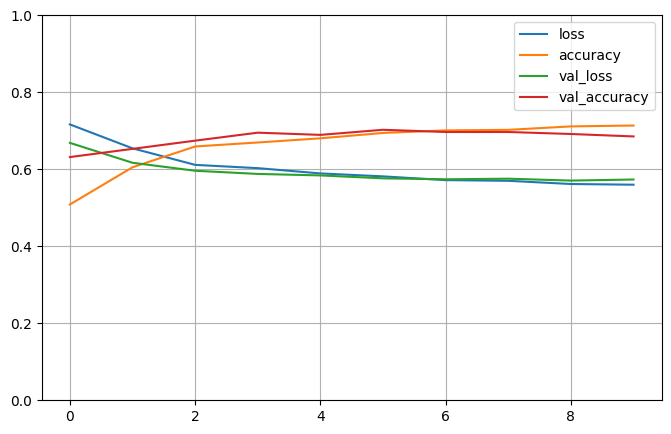

In [12]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()


In [13]:
print(datetime.now())
print("PREDICT")
yhat_pred=model.predict(X_valid, verbose=0)     
yhat_classes=np.where(yhat_pred > 0.5, 1, 0)

print('debug pred',yhat_pred[:3])
print('debug class',yhat_classes[:3])
print(datetime.now())

2023-07-13 16:48:58.571785
PREDICT
debug pred [[0.3295962 ]
 [0.0670445 ]
 [0.35367626]]
debug class [[0]
 [0]
 [0]]
2023-07-13 16:48:58.968164


In [14]:
# In binary classification, recall of the positive class is also known as “sensitivity”
# and recall of the negative class is “specificity”.
def show_performance(y_valid, yhat_classes, yhat_pred):
    accuracy = accuracy_score(y_valid, yhat_classes)*100.
    precision = precision_score(y_valid, yhat_classes)*100.
    recall = recall_score(y_valid, yhat_classes)*100.
    sensitivity = recall_score(y_valid, yhat_classes, pos_label=1)*100.
    specificity = recall_score(y_valid, yhat_classes, pos_label=0)*100.
    f1 = f1_score(y_valid, yhat_classes)*100.
    mcc = matthews_corrcoef(y_valid, yhat_classes)
    if yhat_pred is None:
        # these stats are possible for probabilistic models only
        auprc = 0.
        auroc = 0.
    else:
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_valid, yhat_pred)*100.
    values,counts=np.unique(yhat_classes, return_counts=True)
    print('Predictions: ', dict(zip(values, counts)))
    print('Accuracy: %.2f%% F1: %.2f%% MCC: %.4f' % (accuracy,f1,mcc))
    print('Precision: %.2f%% Recall: %.2f%% AUPRC: %.2f%%' % (precision,recall,auprc))
    print('Sensitivity: %.2f%% Specificity: %.2f%% AUROC: %.2f%%' % (sensitivity,specificity,auroc))


In [15]:
print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
cm1 = confusion_matrix(y_valid,yhat_classes)
print('Confusion matrix\n',cm1)
cm2 = confusion_matrix(y_valid,yhat_classes,normalize='all')
print('Normalized matrix\n',cm2)

show_performance(y_valid, yhat_classes, yhat_pred)

Distrib of scores: 0.4396719 mean 0.23686476 std
Range of scores: 0.044037335 to 0.9316617
Confusion matrix
 [[710 177]
 [369 479]]
Normalized matrix
 [[0.4092219  0.10201729]
 [0.21268012 0.27608069]]
Predictions:  {0: 1079, 1: 656}
Accuracy: 68.53% F1: 63.70% MCC: 0.3766
Precision: 73.02% Recall: 56.49% AUPRC: 76.22%
Sensitivity: 56.49% Specificity: 80.05% AUROC: 77.35%
